In [128]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth, files
# from oauth2client.client import GoogleCredentials


import tensorflow as tf
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.python.keras.applications import xception
from tensorflow.python.keras import optimizers, metrics
from sklearn.model_selection import train_test_split
import scipy.io
import numpy as np, pandas as pd
import PIL


import os
from os import listdir
from os.path import isfile, join

In [ ]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#@title Don't touch it on working machine
!mkdir train
!mkdir test
!mkdir out

# Download a file based on its file ID.
#
files = ['10bcf4_bV-B_GmX_40BDjD7BZjRve-ciw',
'1gdTW4bRF9reGffYwgQoKSfqMjjXoWKNq',
'1-4VuiQHr0mCu8IK28ACPYDxpouxKUNvo',
'19meBzmNDy570ch88u812KuEFXsyt4yPc',
'1Z8bY6e-LWdVd6y-TP3qEe75AURytvGxY',
'1-PpJOwSCbpleYD0Ss81Sm6k-mQvpQx7L',
'1PsUeYCptA1RTpSvQAk7vidPIy5qX0KTN',
'1Qvl-jozmmU2YqOt395Beuuph4ivYJb0T',
'1QZjABkrELGxL7fwYXXD0gKammp86bhhn',
'1ePsQIhQUMPFC7VdFzOhIY0Uf5fZO2igU',
'1RniG4-dOuyBCmTRjfSCH4XWblGs4_wLW',
'1_MqKcZQqzvIWTo3A1y5V54G2ewcDhbEY']
for i in range(12):
    file_id = files[i]
    downloaded = drive.CreateFile({'id': file_id})
    downloaded.GetContentFile('train/train-' + str(i))
    
files_test = ['1BbRXZNOEeumC5M-I5g1UMp0wmqm-lAb5',
'1VEBbO1u5r6mmTAf-WzELwtztVLRwSI11',
'1xb9YunpLd4yEjXflhD2JqJ3I-6mmxDIA',
'19fbyBie2MWeUWYBnz31ztxJeACkEzK-f',
'1ZB6C9dd8oh-gPxGHZPyj57G9tJklcrks',
'13OUxXuy-5XD_9YEXSyMqub2kgv9O9mYg']
for i in range(6):
    file_id = files_test[i]
    downloaded = drive.CreateFile({'id': file_id})
    downloaded.GetContentFile('test/test-' + str(i))

In [3]:
def auc(y_true, y_pred):
    value, update_op = tf.metrics.auc(y_true, y_pred)
    
    with tf.control_dependencies([update_op]):
        value = tf.identity(value, "auc_r")
        return value

base_model = xception.Xception(include_top=False, weights='imagenet', input_shape=(299, 299,3))
x = base_model.output

x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

predictions = Dense(196, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

run_config = tf.estimator.RunConfig()
run_config = run_config.replace(keep_checkpoint_max=5, save_summary_steps=10)
model.compile(optimizer=optimizers.Adam(lr=0.0001), 
              loss='categorical_crossentropy', metrics=['accuracy', metrics.top_k_categorical_accuracy, metrics.mean_absolute_error, auc])
est = tf.keras.estimator.model_to_estimator(model, model_dir='x_input', config=run_config)

83689472/83683744 [==============================]83689472/83683744 [==============================] - 22s 0us/step

INFO:tensorflow:Using the Keras model from memory.
INFO:tensorflow:Using config: {'_model_dir': 'x_input', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f43f24937f0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [2]:
DATASET_FILE = 'cars_annos'
seed = 123
n_threads = 2
image_size=299
BATCH_SIZE=32

In [ ]:
def parse_example_proto(example_serialized):
    # Dense features in Example proto.
    feature_map = {
        'image/encoded': tf.FixedLenFeature([], dtype=tf.string,
                                            default_value=''),
        'image/class/label': tf.FixedLenFeature([1], dtype=tf.int64,
                                                default_value=-1),
        'image/class/text': tf.FixedLenFeature([], dtype=tf.string,
                                               default_value=''),
        'image/height': tf.FixedLenFeature([1], dtype=tf.int64,
                                                default_value=-1),
        'image/width': tf.FixedLenFeature([1], dtype=tf.int64,
                                                default_value=-1),
    }
    sparse_float32 = tf.VarLenFeature(dtype=tf.float32)
    # Sparse features in Example proto.
    feature_map.update(
        {k: sparse_float32 for k in ['image/object/bbox/xmin',
                                     'image/object/bbox/ymin',
                                     'image/object/bbox/xmax',
                                     'image/object/bbox/ymax']})

    features = tf.parse_single_example(example_serialized, feature_map)
    label = tf.cast(features['image/class/label'], dtype=tf.int32)
    label = tf.subtract(label, 1)
    
    label = tf.one_hot(label, depth=196, on_value=1.0, off_value=0.0)
    label = tf.squeeze(label)
    
    xmin = tf.cast(tf.reshape(features['image/object/bbox/xmin'].values, shape=[]), dtype=tf.int32)
    ymin = tf.cast(tf.reshape(features['image/object/bbox/ymin'].values, shape=[]), dtype=tf.int32)
    xmax = tf.cast(tf.reshape(features['image/object/bbox/xmax'].values, shape=[]), dtype=tf.int32)
    ymax = tf.cast(tf.reshape(features['image/object/bbox/ymax'].values, shape=[]), dtype=tf.int32)
    
    tg_y = tf.subtract(ymax, ymin)
    tg_x = tf.subtract(xmax, xmin)

    return features['image/encoded'], label, xmin, ymin, tg_x, tg_y, features['image/class/text']

In [ ]:
def decode_jpeg(image_buffer, scope=None):
    """Decode a JPEG string into one 3-D float image Tensor.

    Args:
      image_buffer: scalar string Tensor.
      scope: Optional scope for name_scope.
    Returns:
      3-D float Tensor with values ranging from [0, 1).
    """
    with tf.name_scope(values=[image_buffer], name=scope,
                       default_name='decode_jpeg'):
        # Decode the string as an RGB JPEG.
        # Note that the resulting image contains an unknown height and width
        # that is set dynamically by decode_jpeg. In other words, the height
        # and width of image is unknown at compile-time.
        image = tf.image.decode_jpeg(image_buffer, channels=3)

        # After this point, all image pixels reside in [0,1)
        # until the very end, when they're rescaled to (-1, 1).  The various
        # adjust_* ops all require this range for dtype float.
        image = tf.image.convert_image_dtype(image, dtype=tf.float32)
        return image

In [ ]:
def apply_with_random_selector(x, func, num_cases):
    """Computes func(x, sel), with sel sampled from [0...num_cases-1].

    Args:
      x: input Tensor.
      func: Python function to apply.
      num_cases: Python int32, number of cases to sample sel from.

    Returns:
      The result of func(x, sel), where func receives the value of the
      selector as a python integer, but sel is sampled dynamically.
    """
    
    sel = tf.random_uniform([], maxval=num_cases, dtype=tf.int32)
    # Pass the real x only to one of the func calls.
    return control_flow_ops.merge([
        func(tf.python.ops.control_flow_ops.switch(x, tf.equal(sel, case))[1], case)
        for case in range(num_cases)])[0]

def image_preprocessing(image_buffer, xmin, ymin, tg_x, tg_y, train=True):

    image = decode_jpeg(image_buffer)

    if train:
        distorted_image = tf.image.crop_to_bounding_box(image, ymin, xmin, tg_y, tg_x)
        distorted_image = tf.image.resize_images(distorted_image, [image_size, image_size],
                                                 method=0)
        distorted_image.set_shape([image_size, image_size, 3])
        distorted_image = tf.image.random_flip_left_right(distorted_image)
        
    else:
        distorted_image = tf.image.crop_to_bounding_box(image, ymin, xmin, tg_y, tg_x)
        distorted_image = tf.image.resize_images(distorted_image, [image_size, image_size], method=0)
        distorted_image.set_shape([image_size, image_size, 3])

    return distorted_image


In [ ]:
def parse_fn(example):
    image, label, xmin, ymin, tg_x, tg_y, _ = parse_example_proto(example)
    image = image_preprocessing(image, xmin, ymin, tg_x, tg_y)
    return {'input_1':image}, label
    

In [ ]:
def input_fn():
    with tf.device('/cpu:0'):
        files = tf.data.Dataset.list_files("train/train-*")
        dataset = files.interleave(tf.data.TFRecordDataset, 1)
        dataset = dataset.apply(tf.contrib.data.shuffle_and_repeat(1150))
        dataset = dataset.map(map_func=parse_fn, num_parallel_calls=n_threads)
        dataset = dataset.batch(batch_size=BATCH_SIZE)
        dataset = dataset.prefetch(buffer_size=BATCH_SIZE)
        iterator = dataset.make_one_shot_iterator()
        batch_features, batch_labels = iterator.get_next()

    return batch_features, batch_labels


def input_test():
    def parse_eval(example):
        image, label, xmin, ymin, tg_x, tg_y, _ = parse_example_proto(example)
        image = image_preprocessing(image, xmin, ymin, tg_x, tg_y, False)
        return {'input_1':image}, label
    
    with tf.device('/cpu:0'):
        files = tf.data.Dataset.list_files("test/test-*")
        dataset = files.interleave(tf.data.TFRecordDataset, 1)
        dataset = dataset.map(map_func=parse_eval, num_parallel_calls=n_threads)
        dataset = dataset.batch(batch_size=BATCH_SIZE)
        dataset = dataset.prefetch(buffer_size=BATCH_SIZE)
        iterator = dataset.make_one_shot_iterator()
        batch_features, batch_labels = iterator.get_next()

    return batch_features, batch_labels

In [ ]:
with tf.device('/gpu:0'):
    est.train(input_fn=input_fn)

In [ ]:
with tf.device('/gpu:0'):
    est.evaluate(input_fn=input_test, name="ch1")

In [ ]:
onlyfiles = ['out/' + f for f in listdir('out') if isfile(join('out', f))]


In [ ]:
def find_folders(fldname):
    file_list = drive.ListFile({
        'q': "title='{}' and mimeType contains 'application/vnd.google-apps.folder' and trashed=false".format(fldname)
        }).GetList()
    return file_list

def upload_files_to_folder(fnames, folder):
    for fname in fnames: 
        nfile = drive.CreateFile({'title':os.path.basename(fname),
                                  'parents':[{u'id': folder['id']}]})
        nfile.SetContentFile(fname)
        nfile.Upload()

In [ ]:
flds = find_folders('kek')
upload_files_to_folder(['out/eval_ch1'], flds[0])

## Presentation stuff

In [ ]:
def read_mat(fname):
    mat = scipy.io.loadmat('../data/' + fname +'.mat')
    df = pd.DataFrame(mat['annotations'][0])
    labels = pd.DataFrame(mat['class_names'][0])
    labels = labels.applymap((lambda x: x[0]))
    df = df.applymap((lambda x: x[0]))
    df.loc[:, df.columns != 'relative_im_path'] = \
        df.loc[:, df.columns != 'relative_im_path'].applymap((lambda x: x[0]))
    return df, labels

dataset, label_map = read_mat(DATASET_FILE)

In [4]:
class ImageCoder(object):
    """Helper class that provides TensorFlow image coding utilities."""

    def __init__(self):
        self._sess = tf.Session()

        self._decode_jpeg_data = tf.placeholder(dtype=tf.string)
        self._decode_jpeg = tf.image.decode_jpeg(self._decode_jpeg_data, channels=3)
        self._to_raw = tf.image.encode_jpeg(self._decode_jpeg, format='rgb', quality=100)

    def decode_jpeg(self, image_data):
        image = self._sess.run(self._decode_jpeg,
                               feed_dict={self._decode_jpeg_data: image_data})
        assert len(image.shape) == 3
        assert image.shape[2] == 3
        return image
    
    def from_file_jpeg(self, filename):
        with tf.gfile.FastGFile(filename, 'rb') as f:
            image_data = f.read()
        image = self.decode_jpeg(image_data)
        height = image.shape[0]
        width = image.shape[1]
        return image_data, height, width
    
    def raws(self, filename):
        with tf.gfile.FastGFile(filename, 'rb') as f:
            image_data = f.read()
        image = self._sess.run(self._decode_jpeg,
                               feed_dict={self._decode_jpeg_data: image_data})
        assert len(image.shape) == 3
        height = image.shape[0]
        width = image.shape[1]
        if image.shape[2] == 3:
            return image_data, height, width
        else:
            image_data = self._sess.run(self._to_raw,
                               feed_dict={self._decode_jpeg_data: image_data})
            return image_data, height, width

In [33]:
coder = ImageCoder()

137 ['Hyundai Sonata Sedan 2012']


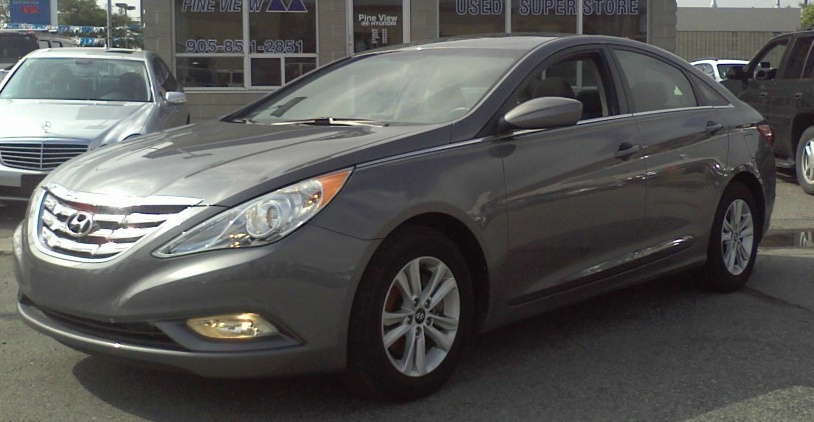

In [131]:
def load_and_show(df, coder, only_test = False):
    if not only_test:
        fname, xmin, ymin, xmax, ymax, label, _ = dataset.values[np.random.randint(0, dataset.shape[0]), :]
    else:
        X = train_test_split(dataset.values, test_size=0.3, random_state=seed, stratify=dataset.values[:, 5])
        fname, xmin, ymin, xmax, ymax, label, _ = X[np.random.randint(0, X.shape[0]), :]
    fname = '../data/' + fname
    img, height, width = coder.raws(fname)
    image = coder.decode_jpeg(img)
    op_crop = tf.image.crop_to_bounding_box(image, ymin, xmin, ymax - ymin, xmax - xmin)
    cropped_image = coder._sess.run(op_crop)
    print(label - 1, label_map.values[label - 1])   # label offset
    return cropped_image
cropped_image = load_and_show(dataset, coder)
PIL.Image.fromarray(cropped_image)

In [134]:
def predict(cropped_image):
    op_net = tf.image.convert_image_dtype(cropped_image, dtype=tf.float32)
    op_net = tf.image.resize_images(op_net, [image_size, image_size],
                                                     method=0)
    op_net.set_shape([image_size, image_size, 3])
    op_net = tf.expand_dims(op_net, 0)
    image_to_net = coder._sess.run(op_net)

    one_input = tf.estimator.inputs.numpy_input_fn({'input_1': image_to_net}, batch_size=1, shuffle=False)
    gen = est.predict(one_input)
    results = list(gen)
    result = np.array(list(results[0].values()))
    res_label = np.argmax(result)
    res_text = label_map.values[res_label]
    print(res_label, res_text)
    return res_label
predict(cropped_image)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from x_input/model.ckpt-4120
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
137 ['Hyundai Sonata Sedan 2012']


137